In [65]:
!pip install optuna

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import optuna
import pickle
import requests
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Dataset

In [112]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/Generated Datasets/End of Season/train_test_dataset.csv')
df.head()

,season_x,element,name,position,GW,gw_points,was_home,minutes,minutes_per_gameweek,prev_game_minutes_1,...,previous_season_yellow_cards_per_game,previous_season_red_cards_per_game,opp_team_goals_scored_per_game,opp_team_xG_per_game,opp_team_goals_conceded_per_game,opp_team_xGA_per_game,opp_team_goals_scored_form,opp_team_goals_conceded_form,opp_team_goalless_games_per_game,opp_team_clean_sheets_per_game
0,2017-18,443,Aaron Cresswell,DEF,1,0,0,9,0.00,0.0,...,0.076923,0.038462,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,2017-18,443,Aaron Cresswell,DEF,2,1,0,90,9.00,9.0,...,0.076923,0.038462,0.000000,2.000000,0.0,0.300000,0.000000,0.0,1.000000,1.0
2,2017-18,443,Aaron Cresswell,DEF,3,1,0,90,49.50,90.0,...,0.076923,0.038462,0.000000,0.750000,1.5,1.400000,0.000000,1.5,1.000000,0.0
3,2017-18,443,Aaron Cresswell,DEF,4,6,1,90,63.00,90.0,...,0.076923,0.038462,1.333333,1.066667,0.0,0.833333,1.333333,0.0,0.333333,1.0
4,2017-18,443,Aaron Cresswell,DEF,5,9,0,90,69.75,90.0,...,0.076923,0.038462,1.000000,1.000000,1.0,0.875000,1.000000,1.0,0.000000,0.5


### Target Variable Exploration

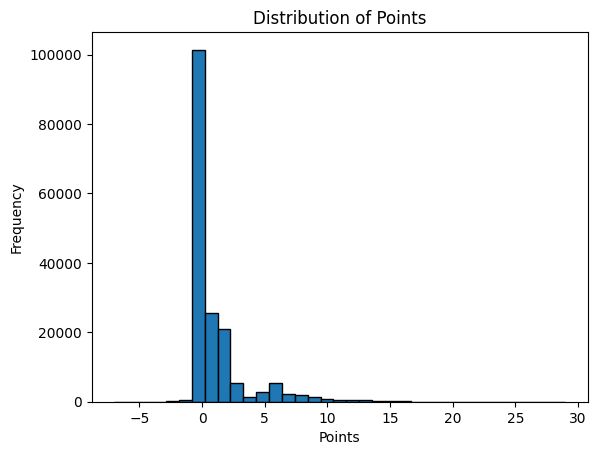

In [113]:
plt.hist(df['gw_points'], bins=35, edgecolor='black')
plt.title('Distribution of Points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.show()

In [114]:
df.columns

Index(['season_x', 'element', 'name', 'position', 'GW', 'gw_points',
       'was_home', 'minutes', 'minutes_per_gameweek', 'prev_game_minutes_1',
       'prev_game_minutes_2', 'prev_game_minutes_3', 'prev_game_minutes_4',
       'prev_game_minutes_5', 'points_per_game', 'form', 'influence_per_game',
       'influence_form', 'creativity_per_game', 'creativity_form',
       'threat_per_game', 'threat_form', 'ict_index_per_game', 'ict_form',
       'bps_per_game', 'bps_form', 'saves_per_game', 'clean_sheets_per_game',
       'yellow_cards_per_game', 'red_cards_per_game',
       'previous_season_minutes_per_gameweek',
       'previous_season_points_per_game', 'previous_season_influence_per_game',
       'previous_season_creativity_per_game',
       'previous_season_threat_per_game', 'previous_season_ict_index_per_game',
       'previous_season_bps_per_game', 'previous_season_saves_per_game',
       'previous_season_clean_sheets_per_game',
       'previous_season_yellow_cards_per_game',
   

### Pre-Processing Data

In [115]:
df = df.drop(['element', 'name', 'minutes'], axis=1)

#df = df.drop(['previous_season_minutes_per_gameweek', 'previous_season_points_per_game', 'previous_season_influence_per_game', 'previous_season_creativity_per_game', 'previous_season_threat_per_game', 'previous_season_ict_index_per_game', 'previous_season_bps_per_game', 'previous_season_saves_per_game', 'previous_season_clean_sheets_per_game', 'previous_season_yellow_cards_per_game', 'previous_season_red_cards_per_game'], axis=1)

#df = df.drop(['prev_game_minutes_1', 'prev_game_minutes_2', 'prev_game_minutes_3', 'prev_game_minutes_4', 'prev_game_minutes_5', 'form', 'influence_form', 'creativity_form', 'threat_form', 'ict_form', 'bps_form', 'opp_team_goals_scored_form', 'opp_team_goals_conceded_form'], axis=1)

#df = df.drop(['influence_per_game', 'influence_form', 'creativity_per_game', 'creativity_form', 'threat_per_game', 'threat_form', 'ict_index_per_game', 'ict_form'], axis=1)

df = df.drop(['was_home'], axis=1)

# Splitting DF by Position

df_GKP = df[df.position == 'GKP']
df_DEF = df[df.position == 'DEF']
df_MID = df[df.position == 'MID']
df_FWD = df[df.position == 'FWD']

# Removing Position

#df_GKP.drop('position', axis=1, inplace=True)
#df_DEF.drop(columns=['position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
#df_MID.drop(columns=['position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
#df_FWD.drop(columns=['position', 'saves_per_game', 'previous_season_saves_per_game', 'clean_sheets_per_game', 'previous_season_clean_sheets_per_game'], axis=1, inplace=True)

df_GKP.drop('position', axis=1, inplace=True)
df_DEF.drop(columns=['position'], axis=1, inplace=True)
df_MID.drop(columns=['position'], axis=1, inplace=True)
df_FWD.drop(columns=['position'], axis=1, inplace=True)

<ipython-input-115-0e14825d89b4>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GKP.drop('position', axis=1, inplace=True)
<ipython-input-115-0e14825d89b4>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_DEF.drop(columns=['position'], axis=1, inplace=True)
<ipython-input-115-0e14825d89b4>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_MID.drop(columns=['position'], axis=1, inplace=True)
<ipython-input-115-0e14825d89b4>

In [116]:
df.columns

Index(['season_x', 'position', 'GW', 'gw_points', 'minutes_per_gameweek',
       'prev_game_minutes_1', 'prev_game_minutes_2', 'prev_game_minutes_3',
       'prev_game_minutes_4', 'prev_game_minutes_5', 'points_per_game', 'form',
       'influence_per_game', 'influence_form', 'creativity_per_game',
       'creativity_form', 'threat_per_game', 'threat_form',
       'ict_index_per_game', 'ict_form', 'bps_per_game', 'bps_form',
       'saves_per_game', 'clean_sheets_per_game', 'yellow_cards_per_game',
       'red_cards_per_game', 'previous_season_minutes_per_gameweek',
       'previous_season_points_per_game', 'previous_season_influence_per_game',
       'previous_season_creativity_per_game',
       'previous_season_threat_per_game', 'previous_season_ict_index_per_game',
       'previous_season_bps_per_game', 'previous_season_saves_per_game',
       'previous_season_clean_sheets_per_game',
       'previous_season_yellow_cards_per_game',
       'previous_season_red_cards_per_game', 'opp_te

### Season-Split

In [117]:
scaler_GKP = MinMaxScaler()

X = df_GKP.drop(columns=['gw_points'])
y = df_GKP[['season_x', 'gw_points']]

X_train_GKP = X[X.season_x != '2023-24']
X_test_GKP = X[X.season_x == '2023-24']
y_train_GKP = y[y.season_x != '2023-24']
y_test_GKP = y[X.season_x == '2023-24']

X_train_GKP = X_train_GKP.drop(columns=['season_x'])
X_test_GKP = X_test_GKP.drop(columns=['season_x'])
y_train_GKP = y_train_GKP.drop(columns=['season_x'])
y_test_GKP = y_test_GKP.drop(columns=['season_x'])

X_train_GKP = scaler_GKP.fit_transform(X_train_GKP)
X_test_GKP = scaler_GKP.transform(X_test_GKP)
y_train_GKP = np.array(y_train_GKP).reshape(-1)
y_test_GKP = np.array(y_test_GKP).reshape(-1)

In [118]:
scaler_DEF = MinMaxScaler()

X = df_DEF.drop(columns=['gw_points'])
y = df_DEF[['season_x', 'gw_points']]

X_train_DEF = X[X.season_x != '2023-24']
X_test_DEF = X[X.season_x == '2023-24']
y_train_DEF = y[y.season_x != '2023-24']
y_test_DEF = y[X.season_x == '2023-24']

X_train_DEF = X_train_DEF.drop(columns=['season_x'])
X_test_DEF = X_test_DEF.drop(columns=['season_x'])
y_train_DEF = y_train_DEF.drop(columns=['season_x'])
y_test_DEF = y_test_DEF.drop(columns=['season_x'])

X_train_DEF = scaler_DEF.fit_transform(X_train_DEF)
X_test_DEF = scaler_DEF.transform(X_test_DEF)
y_train_DEF = np.array(y_train_DEF).reshape(-1)
y_test_DEF = np.array(y_test_DEF).reshape(-1)

In [119]:
scaler_MID = MinMaxScaler()

X = df_MID.drop(columns=['gw_points'])
y = df_MID[['season_x', 'gw_points']]

X_train_MID = X[X.season_x != '2023-24']
X_test_MID = X[X.season_x == '2023-24']
y_train_MID = y[y.season_x != '2023-24']
y_test_MID = y[X.season_x == '2023-24']

X_train_MID = X_train_MID.drop(columns=['season_x'])
X_test_MID = X_test_MID.drop(columns=['season_x'])
y_train_MID = y_train_MID.drop(columns=['season_x'])
y_test_MID = y_test_MID.drop(columns=['season_x'])

X_train_MID = scaler_MID.fit_transform(X_train_MID)
X_test_MID = scaler_MID.transform(X_test_MID)
y_train_MID = np.array(y_train_MID).reshape(-1)
y_test_MID = np.array(y_test_MID).reshape(-1)

In [120]:
scaler_FWD = MinMaxScaler()

X = df_FWD.drop(columns=['gw_points'])
y = df_FWD[['season_x', 'gw_points']]

X_train_FWD = X[X.season_x != '2023-24']
X_test_FWD = X[X.season_x == '2023-24']
y_train_FWD = y[y.season_x != '2023-24']
y_test_FWD = y[X.season_x == '2023-24']

X_train_FWD = X_train_FWD.drop(columns=['season_x'])
X_test_FWD = X_test_FWD.drop(columns=['season_x'])
y_train_FWD = y_train_FWD.drop(columns=['season_x'])
y_test_FWD = y_test_FWD.drop(columns=['season_x'])

X_train_FWD = scaler_FWD.fit_transform(X_train_FWD)
X_test_FWD = scaler_FWD.transform(X_test_FWD)
y_train_FWD = np.array(y_train_FWD).reshape(-1)
y_test_FWD = np.array(y_test_FWD).reshape(-1)

### Splitting Data & Normalisation

In [ ]:
# GKP

scaler_GKP = MinMaxScaler()

X = df_GKP.drop(columns=['gw_points'])
y = df_GKP['gw_points']

X_train_GKP, X_test_GKP, y_train_GKP, y_test_GKP = train_test_split(X, y, test_size = 0.17, random_state = 2)

X_train_GKP.to_csv('X.csv', index=False)

X_train_GKP = scaler_GKP.fit_transform(X_train_GKP)
X_test_GKP = scaler_GKP.transform(X_test_GKP)

# DEF

scaler_DEF = MinMaxScaler()

X = df_DEF.drop(columns=['gw_points'])
y = df_DEF['gw_points']

X_train_DEF, X_test_DEF, y_train_DEF, y_test_DEF = train_test_split(X, y, test_size = 0.17, random_state = 2)

X_train_DEF = scaler_DEF.fit_transform(X_train_DEF)
X_test_DEF = scaler_DEF.transform(X_test_DEF)

# MID

scaler_MID = MinMaxScaler()

X = df_MID.drop(columns=['gw_points'])
y = df_MID['gw_points']

X_train_MID, X_test_MID, y_train_MID, y_test_MID = train_test_split(X, y, test_size = 0.17, random_state = 2)

X_train_MID = scaler_MID.fit_transform(X_train_MID)
X_test_MID = scaler_MID.transform(X_test_MID)

# FWD

scaler_FWD = MinMaxScaler()

X = df_FWD.drop(columns=['gw_points'])
y = df_FWD['gw_points']

X_train_FWD, X_test_FWD, y_train_FWD, y_test_FWD = train_test_split(X, y, test_size = 0.17, random_state = 2)

X_train_FWD = scaler_FWD.fit_transform(X_train_FWD)
X_test_FWD = scaler_FWD.transform(X_test_FWD)

### Dummy Regressors

In [ ]:
df_GKP

,season_x,GW,gw_points,was_home,minutes_per_gameweek,prev_game_minutes_1,prev_game_minutes_2,prev_game_minutes_3,prev_game_minutes_4,prev_game_minutes_5,...,previous_season_yellow_cards_per_game,previous_season_red_cards_per_game,opp_team_goals_scored_per_game,opp_team_xG_per_game,opp_team_goals_conceded_per_game,opp_team_xGA_per_game,opp_team_goals_scored_form,opp_team_goals_conceded_form,opp_team_goalless_games_per_game,opp_team_clean_sheets_per_game
114,2017-18,6,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.400000,0.720000,2.000000,1.440000,0.4,2.0,0.600000,0.200000
115,2017-18,7,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.500000,1.650000,2.000000,1.450000,1.2,1.6,0.166667,0.166667
116,2017-18,8,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.000000,1.585714,0.714286,0.614286,2.2,0.6,0.142857,0.571429
117,2017-18,9,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.125000,1.000000,2.250000,1.700000,1.4,3.2,0.250000,0.125000
118,2017-18,10,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.888889,1.044444,1.111111,1.088889,1.8,1.0,0.222222,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172810,2023-24,35,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.235294,1.276471,1.764706,1.391176,1.4,1.8,0.264706,0.117647
172811,2023-24,36,0,1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.371429,1.274286,1.571429,1.625714,1.0,1.6,0.228571,0.142857
172812,2023-24,37,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.416667,1.377778,1.527778,1.605556,0.8,1.0,0.333333,0.277778
172813,2023-24,37,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.972222,1.755556,1.638889,1.669444,1.2,2.8,0.083333,0.166667


In [ ]:
class dummy_GKP():
  def predict(df_GKP, X_test_GKP):
    df_GKP = df_GKP[df_GKP['season_x'] == '2023-24']

    pred = [df_GKP['gw_points'].mean()] * len(X_test_GKP)

    return pred

In [ ]:
class dummy_DEF():
  def predict(df_DEF, X_test_DEF):
    df_DEF = df_DEF[df_DEF['season_x'] == '2023-24']

    pred = [df_DEF['gw_points'].mean()] * len(X_test_DEF)

    return pred

In [ ]:
class dummy_MID():
  def predict(df_MID, X_test_MID):
    df_MID = df_MID[df_MID['season_x'] == '2023-24']

    pred = [df_MID['gw_points'].mean()] * len(X_test_MID)

    return pred

In [ ]:
class dummy_FWD():
  def predict(df_FWD, X_test_FWD):
    df_FWD = df_FWD[df_FWD['season_x'] == '2023-24']

    pred = [df_FWD['gw_points'].mean()] * len(X_test_FWD)

    return pred

## Hyper-Parameter Tuning

### Decision Trees

#### GKP

In [ ]:
def objective(trial):
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = DecisionTreeRegressor(splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_GKP, y_train_GKP)
  y_pred = model.predict(X_test_GKP)
  return mean_squared_error(y_test_GKP, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

dt_GKP = DecisionTreeRegressor(**best_params, random_state=0)

[I 2024-05-27 00:52:58,824] A new study created in memory with name: no-name-6fde4082-65ce-4b76-818a-b35f838f5c77
[I 2024-05-27 00:52:59,113] Trial 0 finished with value: 2.1483918751731723 and parameters: {'splitter': 'best', 'min_samples_split': 491, 'min_samples_leaf': 195}. Best is trial 0 with value: 2.1483918751731723.
[I 2024-05-27 00:52:59,257] Trial 1 finished with value: 2.2042587077644407 and parameters: {'splitter': 'best', 'min_samples_split': 53, 'min_samples_leaf': 904}. Best is trial 0 with value: 2.1483918751731723.
[I 2024-05-27 00:52:59,486] Trial 2 finished with value: 2.106633423309273 and parameters: {'splitter': 'best', 'min_samples_split': 745, 'min_samples_leaf': 665}. Best is trial 2 with value: 2.106633423309273.
[I 2024-05-27 00:52:59,695] Trial 3 finished with value: 2.2318640069338547 and parameters: {'splitter': 'best', 'min_samples_split': 411, 'min_samples_leaf': 952}. Best is trial 2 with value: 2.106633423309273.
[I 2024-05-27 00:53:00,071] Trial 4 fi

#### DEF

In [ ]:
def objective(trial):
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = DecisionTreeRegressor(splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_DEF, y_train_DEF)
  y_pred = model.predict(X_test_DEF)
  return mean_squared_error(y_test_DEF, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

dt_DEF = DecisionTreeRegressor(**best_params, random_state=0)

[I 2024-05-26 08:46:00,384] A new study created in memory with name: no-name-cb48dd98-54ee-414e-bedb-9b0c65b3192b
[I 2024-05-26 08:46:00,565] Trial 0 finished with value: 3.8433671593941474 and parameters: {'splitter': 'best', 'min_samples_split': 161, 'min_samples_leaf': 692, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.8433671593941474.
[I 2024-05-26 08:46:00,687] Trial 1 finished with value: 3.865469197326143 and parameters: {'splitter': 'best', 'min_samples_split': 695, 'min_samples_leaf': 982, 'max_features': 'log2'}. Best is trial 0 with value: 3.8433671593941474.
[I 2024-05-26 08:46:00,726] Trial 2 finished with value: 3.953625620945096 and parameters: {'splitter': 'random', 'min_samples_split': 431, 'min_samples_leaf': 559, 'max_features': 'log2'}. Best is trial 0 with value: 3.8433671593941474.
[I 2024-05-26 08:46:00,966] Trial 3 finished with value: 3.8489102340327515 and parameters: {'splitter': 'random', 'min_samples_split': 219, 'min_samples_leaf': 438, 'max_feat

#### MID

In [ ]:
def objective(trial):
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = DecisionTreeRegressor(splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_MID, y_train_MID)
  y_pred = model.predict(X_test_MID)
  return mean_squared_error(y_test_MID, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

dt_MID = DecisionTreeRegressor(**best_params, random_state=0)

[I 2024-05-26 08:46:42,907] A new study created in memory with name: no-name-6a1fe124-6dd9-4fd8-9bee-d2eb6a617947
[I 2024-05-26 08:46:43,144] Trial 0 finished with value: 3.866831300044854 and parameters: {'splitter': 'random', 'min_samples_split': 178, 'min_samples_leaf': 709, 'max_features': None}. Best is trial 0 with value: 3.866831300044854.
[I 2024-05-26 08:46:43,203] Trial 1 finished with value: 3.9099405436600665 and parameters: {'splitter': 'random', 'min_samples_split': 818, 'min_samples_leaf': 69, 'max_features': 'log2'}. Best is trial 0 with value: 3.866831300044854.
[I 2024-05-26 08:46:43,515] Trial 2 finished with value: 3.9222369616900425 and parameters: {'splitter': 'best', 'min_samples_split': 197, 'min_samples_leaf': 27, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.866831300044854.
[I 2024-05-26 08:46:43,865] Trial 3 finished with value: 3.8720450272939217 and parameters: {'splitter': 'random', 'min_samples_split': 643, 'min_samples_leaf': 3, 'max_features':

#### FWD

In [ ]:
def objective(trial):
  splitter = trial.suggest_categorical('splitter', ['best', 'random'])
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = DecisionTreeRegressor(splitter=splitter, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_FWD, y_train_FWD)
  y_pred = model.predict(X_test_FWD)
  return mean_squared_error(y_test_FWD, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

dt_FWD = DecisionTreeRegressor(**best_params, random_state=0)

[I 2024-05-26 08:46:54,054] A new study created in memory with name: no-name-b28bd017-10f4-41a9-acfb-59c763e5efbd
[I 2024-05-26 08:46:54,089] Trial 0 finished with value: 4.627783316443845 and parameters: {'splitter': 'best', 'min_samples_split': 914, 'min_samples_leaf': 602, 'max_features': 'log2'}. Best is trial 0 with value: 4.627783316443845.
[I 2024-05-26 08:46:54,102] Trial 1 finished with value: 4.806009162293508 and parameters: {'splitter': 'random', 'min_samples_split': 614, 'min_samples_leaf': 358, 'max_features': 'log2'}. Best is trial 0 with value: 4.627783316443845.
[I 2024-05-26 08:46:54,146] Trial 2 finished with value: 4.657332269527973 and parameters: {'splitter': 'best', 'min_samples_split': 554, 'min_samples_leaf': 296, 'max_features': 'sqrt'}. Best is trial 0 with value: 4.627783316443845.
[I 2024-05-26 08:46:54,327] Trial 3 finished with value: 4.563504881921603 and parameters: {'splitter': 'best', 'min_samples_split': 392, 'min_samples_leaf': 548, 'max_features': 

### Random Forests

#### GKP

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_GKP, y_train_GKP)
  y_pred = model.predict(X_test_GKP)
  return mean_squared_error(y_test_GKP, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

rf_GKP = RandomForestRegressor(**best_params, random_state=0)

[I 2024-05-24 18:42:12,030] A new study created in memory with name: no-name-7c19f7c1-03bc-4b2c-84f2-198918ff457c
[I 2024-05-24 18:42:28,322] Trial 0 finished with value: 2.0182246807265876 and parameters: {'n_estimators': 460, 'min_samples_split': 324, 'min_samples_leaf': 104, 'max_features': 'log2'}. Best is trial 0 with value: 2.0182246807265876.
[I 2024-05-24 18:42:35,702] Trial 1 finished with value: 2.0772791822155683 and parameters: {'n_estimators': 285, 'min_samples_split': 43, 'min_samples_leaf': 845, 'max_features': 'log2'}. Best is trial 0 with value: 2.0182246807265876.
[I 2024-05-24 18:43:08,981] Trial 2 finished with value: 2.00312395304871 and parameters: {'n_estimators': 223, 'min_samples_split': 38, 'min_samples_leaf': 151, 'max_features': None}. Best is trial 2 with value: 2.00312395304871.
[I 2024-05-24 18:43:13,251] Trial 3 finished with value: 2.067266804356556 and parameters: {'n_estimators': 496, 'min_samples_split': 565, 'min_samples_leaf': 646, 'max_features': 

#### DEF

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_DEF, y_train_DEF)
  y_pred = model.predict(X_test_DEF)
  return mean_squared_error(y_test_DEF, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

rf_DEF = RandomForestRegressor(**best_params, random_state=0)

[I 2024-05-24 18:54:20,444] A new study created in memory with name: no-name-ea6c45b7-986c-44e7-8880-4d8a5081e617
[I 2024-05-24 18:54:34,115] Trial 0 finished with value: 3.8031623039602565 and parameters: {'n_estimators': 221, 'min_samples_split': 12, 'min_samples_leaf': 791, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.8031623039602565.
[I 2024-05-24 18:54:43,503] Trial 1 finished with value: 3.801426070602546 and parameters: {'n_estimators': 180, 'min_samples_split': 302, 'min_samples_leaf': 589, 'max_features': 'log2'}. Best is trial 1 with value: 3.801426070602546.
[I 2024-05-24 18:55:18,694] Trial 2 finished with value: 3.770316465897842 and parameters: {'n_estimators': 397, 'min_samples_split': 721, 'min_samples_leaf': 155, 'max_features': 'sqrt'}. Best is trial 2 with value: 3.770316465897842.
[I 2024-05-24 18:56:43,275] Trial 3 finished with value: 3.7719659795987828 and parameters: {'n_estimators': 222, 'min_samples_split': 787, 'min_samples_leaf': 719, 'max_feature

#### MID

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_MID, y_train_MID)
  y_pred = model.predict(X_test_MID)
  return mean_squared_error(y_test_MID, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

rf_MID = RandomForestRegressor(**best_params, random_state=0)

[I 2024-05-24 20:41:56,989] A new study created in memory with name: no-name-83622378-72d5-4107-a030-695bf09dcf7c
[I 2024-05-24 20:42:26,985] Trial 0 finished with value: 3.831211659662709 and parameters: {'n_estimators': 310, 'min_samples_split': 488, 'min_samples_leaf': 396, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.831211659662709.
[I 2024-05-24 20:42:46,641] Trial 1 finished with value: 3.86870899911305 and parameters: {'n_estimators': 280, 'min_samples_split': 538, 'min_samples_leaf': 692, 'max_features': 'log2'}. Best is trial 0 with value: 3.831211659662709.
[I 2024-05-24 20:43:04,966] Trial 2 finished with value: 3.865786618342937 and parameters: {'n_estimators': 240, 'min_samples_split': 546, 'min_samples_leaf': 979, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.831211659662709.
[I 2024-05-24 20:43:24,370] Trial 3 finished with value: 3.88256842629621 and parameters: {'n_estimators': 320, 'min_samples_split': 168, 'min_samples_leaf': 971, 'max_features': 

#### FWD

In [ ]:
def objective(trial):
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = RandomForestRegressor(n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=0)

  model.fit(X_train_FWD, y_train_FWD)
  y_pred = model.predict(X_test_FWD)
  return mean_squared_error(y_test_FWD, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_trial.params

rf_FWD = RandomForestRegressor(**best_params, random_state=0)

[I 2024-05-24 23:24:32,411] A new study created in memory with name: no-name-b75f997c-8a1d-48e7-9fa4-e21eb3499973
[I 2024-05-24 23:24:57,110] Trial 0 finished with value: 4.491204176551277 and parameters: {'n_estimators': 226, 'min_samples_split': 321, 'min_samples_leaf': 518, 'max_features': None}. Best is trial 0 with value: 4.491204176551277.
[I 2024-05-24 23:25:33,866] Trial 1 finished with value: 4.5162949990270125 and parameters: {'n_estimators': 414, 'min_samples_split': 881, 'min_samples_leaf': 730, 'max_features': None}. Best is trial 0 with value: 4.491204176551277.
[I 2024-05-24 23:25:43,341] Trial 2 finished with value: 4.486366487553411 and parameters: {'n_estimators': 310, 'min_samples_split': 460, 'min_samples_leaf': 90, 'max_features': 'sqrt'}. Best is trial 2 with value: 4.486366487553411.
[I 2024-05-24 23:25:50,568] Trial 3 finished with value: 4.5788633192835295 and parameters: {'n_estimators': 476, 'min_samples_split': 923, 'min_samples_leaf': 833, 'max_features': '

### Gradient Boosting Machines

#### GKP

In [ ]:
def objective(trial):
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  subsample = trial.suggest_float('subsample', 0, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  #max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, max_features=None, random_state=0)

  model.fit(X_train_GKP, y_train_GKP)
  y_pred = model.predict(X_test_GKP)
  return mean_squared_error(y_test_GKP, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

gb_GKP = GradientBoostingRegressor(**best_params, max_features=None, random_state=0)

[I 2024-05-26 09:12:45,366] A new study created in memory with name: no-name-d5806a94-097b-4c3d-835c-176bbad86102
[I 2024-05-26 09:12:56,034] Trial 0 finished with value: 2.0663752126611863 and parameters: {'learning_rate': 0.05728629524373338, 'n_estimators': 315, 'subsample': 0.25621673290429103, 'min_samples_split': 72, 'min_samples_leaf': 44}. Best is trial 0 with value: 2.0663752126611863.
[I 2024-05-26 09:12:56,228] Trial 1 finished with value: 3.5071291437768255 and parameters: {'learning_rate': 0.05477021443748356, 'n_estimators': 113, 'subsample': 0.06690573115920362, 'min_samples_split': 80, 'min_samples_leaf': 862}. Best is trial 0 with value: 2.0663752126611863.
[I 2024-05-26 09:13:07,190] Trial 2 finished with value: 2.052799864861137 and parameters: {'learning_rate': 0.08220355427650906, 'n_estimators': 266, 'subsample': 0.5542615993101864, 'min_samples_split': 710, 'min_samples_leaf': 26}. Best is trial 2 with value: 2.052799864861137.
[I 2024-05-26 09:13:29,064] Trial 3

#### DEF

In [ ]:
def objective(trial):
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  subsample = trial.suggest_float('subsample', 0, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  #max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, max_features=None, random_state=0)

  model.fit(X_train_DEF, y_train_DEF)
  y_pred = model.predict(X_test_DEF)
  return mean_squared_error(y_test_DEF, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

gb_DEF = GradientBoostingRegressor(**best_params, max_features=None, random_state=0)

[I 2024-05-26 09:21:34,729] A new study created in memory with name: no-name-acbc6eaa-9eea-4f15-a868-2311c0d26594
[I 2024-05-26 09:21:55,151] Trial 0 finished with value: 3.75795072701724 and parameters: {'learning_rate': 0.06908180516743921, 'n_estimators': 394, 'subsample': 0.14213945963704067, 'min_samples_split': 884, 'min_samples_leaf': 683}. Best is trial 0 with value: 3.75795072701724.
[I 2024-05-26 09:22:08,789] Trial 1 finished with value: 3.950599259264139 and parameters: {'learning_rate': 0.009004543718868925, 'n_estimators': 120, 'subsample': 0.3338808406771814, 'min_samples_split': 48, 'min_samples_leaf': 489}. Best is trial 0 with value: 3.75795072701724.
[I 2024-05-26 09:22:48,175] Trial 2 finished with value: 3.7487071583478433 and parameters: {'learning_rate': 0.03372985902424943, 'n_estimators': 391, 'subsample': 0.29278204989189294, 'min_samples_split': 126, 'min_samples_leaf': 192}. Best is trial 2 with value: 3.7487071583478433.
[I 2024-05-26 09:23:53,888] Trial 3 

#### MID

In [ ]:
def objective(trial):
  learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  subsample = trial.suggest_float('subsample', 0, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  #max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, max_features=None, random_state=0)

  model.fit(X_train_MID, y_train_MID)
  y_pred = model.predict(X_test_MID)
  return mean_squared_error(y_test_MID, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

gb_MID = GradientBoostingRegressor(**best_params, max_features=None, random_state=0)

[I 2024-05-26 09:58:10,353] A new study created in memory with name: no-name-8f93906f-cd86-468b-a487-7c4873da09ce
[I 2024-05-26 09:58:35,683] Trial 0 finished with value: 3.7796686314391708 and parameters: {'learning_rate': 0.035957553271495996, 'n_estimators': 126, 'subsample': 0.4550456617873577, 'min_samples_split': 316, 'min_samples_leaf': 66}. Best is trial 0 with value: 3.7796686314391708.
[I 2024-05-26 10:00:22,229] Trial 1 finished with value: 3.7650360451530083 and parameters: {'learning_rate': 0.043578662562718425, 'n_estimators': 475, 'subsample': 0.5542908304270322, 'min_samples_split': 976, 'min_samples_leaf': 899}. Best is trial 1 with value: 3.7650360451530083.
[I 2024-05-26 10:01:27,169] Trial 2 finished with value: 3.7599247455639726 and parameters: {'learning_rate': 0.03975127897972234, 'n_estimators': 175, 'subsample': 0.945064135554118, 'min_samples_split': 508, 'min_samples_leaf': 119}. Best is trial 2 with value: 3.7599247455639726.
[I 2024-05-26 10:02:28,069] Tri

#### FWD

In [ ]:
def objective(trial):
  learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1)
  n_estimators = trial.suggest_int('n_estimators', 100, 500)
  subsample = trial.suggest_float('subsample', 0, 1)
  min_samples_split = trial.suggest_int('min_samples_split', 2, 1000)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
  #max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

  model = GradientBoostingRegressor(learning_rate=learning_rate, n_estimators=n_estimators, subsample=subsample, min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf, max_features=None, random_state=0)

  model.fit(X_train_FWD, y_train_FWD)
  y_pred = model.predict(X_test_FWD)
  return mean_squared_error(y_test_FWD, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

gb_FWD = GradientBoostingRegressor(**best_params, max_features=None, random_state=0)

[I 2024-05-26 10:57:52,892] A new study created in memory with name: no-name-a9470af2-b436-40a8-be96-741c2ca0f868
[I 2024-05-26 10:58:00,411] Trial 0 finished with value: 4.431743516462545 and parameters: {'learning_rate': 0.01564303837746958, 'n_estimators': 424, 'subsample': 0.14834467960981823, 'min_samples_split': 596, 'min_samples_leaf': 252}. Best is trial 0 with value: 4.431743516462545.
[I 2024-05-26 10:58:09,951] Trial 1 finished with value: 4.4444655453191855 and parameters: {'learning_rate': 0.06270682627671059, 'n_estimators': 210, 'subsample': 0.40309412780782383, 'min_samples_split': 492, 'min_samples_leaf': 950}. Best is trial 0 with value: 4.431743516462545.
[I 2024-05-26 10:58:27,618] Trial 2 finished with value: 4.451914138193373 and parameters: {'learning_rate': 0.0704520434909858, 'n_estimators': 246, 'subsample': 0.6197416633282907, 'min_samples_split': 895, 'min_samples_leaf': 166}. Best is trial 0 with value: 4.431743516462545.
[I 2024-05-26 10:58:42,119] Trial 3

### Fully Connected Neural Network

#### GKP

In [ ]:
def create_model(trial):
    model = Sequential()
    model.add(Dense(43, input_dim=43, activation='relu'))
    n_layers = trial.suggest_int("n_layers", 1, 3)

    for i in range(n_layers):
        n_units = trial.suggest_int(f"n_units_l{i}", 2, 43)
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    else:
        optimizer = SGD(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def create_model_with_best_params(best_params):
    model = Sequential()
    model.add(Dense(43, input_dim=43, activation='relu'))
    n_layers = best_params["n_layers"]

    for i in range(n_layers):
        n_units = best_params[f"n_units_l{i}"]
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = best_params["optimizer"]
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=best_params["learning_rate"])
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=best_params["learning_rate"])
    else:
        optimizer = SGD(learning_rate=best_params["learning_rate"])

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_GKP, y_train_GKP, epochs=trial.suggest_int("epochs", 20, 100), batch_size=trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), verbose=0)
    loss = model.evaluate(X_test_GKP, y_test_GKP, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)
best_params = study.best_params

nn_GKP = create_model_with_best_params(best_params)
nn_GKP.fit(X_train_GKP, y_train_GKP, epochs=best_params["epochs"], batch_size=best_params["batch_size"])

[I 2024-05-25 15:13:08,058] A new study created in memory with name: no-name-af9b0431-ab0c-476c-9121-39ebbb7e9749
[I 2024-05-25 15:13:19,908] Trial 0 finished with value: 2.091707706451416 and parameters: {'n_layers': 2, 'n_units_l0': 22, 'n_units_l1': 35, 'optimizer': 'Adam', 'learning_rate': 0.0060115046536981685, 'epochs': 26, 'batch_size': 128}. Best is trial 0 with value: 2.091707706451416.
[I 2024-05-25 15:14:18,893] Trial 1 finished with value: 2.136566638946533 and parameters: {'n_layers': 2, 'n_units_l0': 30, 'n_units_l1': 12, 'optimizer': 'RMSprop', 'learning_rate': 0.031883158053773536, 'epochs': 61, 'batch_size': 32}. Best is trial 0 with value: 2.091707706451416.
[I 2024-05-25 15:16:41,874] Trial 2 finished with value: 2.0068349838256836 and parameters: {'n_layers': 2, 'n_units_l0': 20, 'n_units_l1': 20, 'optimizer': 'SGD', 'learning_rate': 0.003669558883563995, 'epochs': 49, 'batch_size': 16}. Best is trial 2 with value: 2.0068349838256836.
[I 2024-05-25 15:16:53,751] Tri

Epoch 1/30
491/491 [==============================] - 2s 2ms/step - loss: 4.2500
Epoch 2/30
491/491 [==============================] - 1s 2ms/step - loss: 3.0511
Epoch 3/30
491/491 [==============================] - 1s 2ms/step - loss: 2.9836
Epoch 4/30
491/491 [==============================] - 1s 2ms/step - loss: 2.9398
Epoch 5/30
491/491 [==============================] - 1s 3ms/step - loss: 2.9199
Epoch 6/30
491/491 [==============================] - 2s 4ms/step - loss: 2.8988
Epoch 7/30
491/491 [==============================] - 2s 4ms/step - loss: 2.8910
Epoch 8/30
491/491 [==============================] - 1s 3ms/step - loss: 2.8825
Epoch 9/30
491/491 [==============================] - 1s 2ms/step - loss: 2.8744
Epoch 10/30
491/491 [==============================] - 1s 2ms/step - loss: 2.8711
Epoch 11/30
491/491 [==============================] - 1s 2ms/step - loss: 2.8693
Epoch 12/30
491/491 [==============================] - 1s 2ms/step - loss: 2.8621
Epoch 13/30
491/491 [====

In [ ]:
with open('nn_GKP.pkl', 'wb') as f:
    pickle.dump(nn_GKP, f)

files.download('nn_GKP.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### DEF

In [ ]:
def create_model(trial):
    model = Sequential()
    model.add(Dense(41, input_dim=41, activation='relu'))
    n_layers = trial.suggest_int("n_layers", 1, 3)

    for i in range(n_layers):
        n_units = trial.suggest_int(f"n_units_l{i}", 2, 41)
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    else:
        optimizer = SGD(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def create_model_with_best_params(best_params):
    model = Sequential()
    model.add(Dense(41, input_dim=41, activation='relu'))
    n_layers = best_params["n_layers"]

    for i in range(n_layers):
        n_units = best_params[f"n_units_l{i}"]
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = best_params["optimizer"]
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=best_params["learning_rate"])
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=best_params["learning_rate"])
    else:
        optimizer = SGD(learning_rate=best_params["learning_rate"])

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_DEF, y_train_DEF, epochs=trial.suggest_int("epochs", 20, 100), batch_size=trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), verbose=0)
    loss = model.evaluate(X_test_DEF, y_test_DEF, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

nn_DEF = create_model_with_best_params(best_params)
nn_DEF.fit(X_train_DEF, y_train_DEF, epochs=best_params["epochs"], batch_size=best_params["batch_size"])

[I 2024-05-25 11:02:27,469] A new study created in memory with name: no-name-69668f8b-d0b9-4a48-9325-874bab23ee89
[I 2024-05-25 11:08:51,235] Trial 0 finished with value: 4.011292457580566 and parameters: {'n_layers': 1, 'n_units_l0': 37, 'optimizer': 'SGD', 'learning_rate': 0.02242218914729171, 'epochs': 71, 'batch_size': 16}. Best is trial 0 with value: 4.011292457580566.
[I 2024-05-25 11:16:15,108] Trial 1 finished with value: 4.95371150970459 and parameters: {'n_layers': 3, 'n_units_l0': 2, 'n_units_l1': 23, 'n_units_l2': 39, 'optimizer': 'RMSprop', 'learning_rate': 0.010529953064660357, 'epochs': 70, 'batch_size': 16}. Best is trial 0 with value: 4.011292457580566.
[I 2024-05-25 11:16:57,378] Trial 2 finished with value: 3.868743658065796 and parameters: {'n_layers': 1, 'n_units_l0': 20, 'optimizer': 'SGD', 'learning_rate': 0.08752772737543453, 'epochs': 75, 'batch_size': 256}. Best is trial 2 with value: 3.868743658065796.
[I 2024-05-25 11:24:03,550] Trial 3 finished with value: 

Epoch 1/39
385/385 [==============================] - 2s 2ms/step - loss: 5.1969
Epoch 2/39
385/385 [==============================] - 1s 3ms/step - loss: 4.7153
Epoch 3/39
385/385 [==============================] - 1s 3ms/step - loss: 4.6697
Epoch 4/39
385/385 [==============================] - 1s 3ms/step - loss: 4.6509
Epoch 5/39
385/385 [==============================] - 1s 2ms/step - loss: 4.6378
Epoch 6/39
385/385 [==============================] - 1s 2ms/step - loss: 4.6316
Epoch 7/39
385/385 [==============================] - 2s 4ms/step - loss: 4.6250
Epoch 8/39
385/385 [==============================] - 1s 4ms/step - loss: 4.6241
Epoch 9/39
385/385 [==============================] - 1s 4ms/step - loss: 4.6182
Epoch 10/39
385/385 [==============================] - 1s 3ms/step - loss: 4.6170
Epoch 11/39
385/385 [==============================] - 1s 2ms/step - loss: 4.6133
Epoch 12/39
385/385 [==============================] - 1s 2ms/step - loss: 4.6081
Epoch 13/39
385/385 [====

In [ ]:
with open('nn_DEF.pkl', 'wb') as f:
    pickle.dump(nn_DEF, f)

files.download('nn_DEF.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### MID

In [ ]:
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_MID, y_train_MID, epochs=trial.suggest_int("epochs", 20, 100), batch_size=trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), verbose=0)
    loss = model.evaluate(X_test_MID, y_test_MID, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

nn_MID = create_model_with_best_params(best_params)
nn_MID.fit(X_train_MID, y_train_MID, epochs=best_params["epochs"], batch_size=best_params["batch_size"])

[I 2024-05-25 15:27:23,486] A new study created in memory with name: no-name-bf1035c8-e188-450f-add9-979dc9361f1d
[I 2024-05-25 15:27:45,348] Trial 0 finished with value: 3.7332375049591064 and parameters: {'n_layers': 2, 'n_units_l0': 4, 'n_units_l1': 9, 'optimizer': 'Adam', 'learning_rate': 0.007281375160732116, 'epochs': 24, 'batch_size': 256}. Best is trial 0 with value: 3.7332375049591064.
[I 2024-05-25 15:28:13,473] Trial 1 finished with value: 3.7409722805023193 and parameters: {'n_layers': 3, 'n_units_l0': 15, 'n_units_l1': 25, 'n_units_l2': 38, 'optimizer': 'Adam', 'learning_rate': 0.0003083998367119581, 'epochs': 40, 'batch_size': 256}. Best is trial 0 with value: 3.7332375049591064.
[I 2024-05-25 15:29:37,608] Trial 2 finished with value: 3.798588752746582 and parameters: {'n_layers': 1, 'n_units_l0': 41, 'optimizer': 'SGD', 'learning_rate': 0.0008860339331389813, 'epochs': 94, 'batch_size': 128}. Best is trial 0 with value: 3.7332375049591064.
[I 2024-05-25 15:30:19,974] Tr

Epoch 1/94
464/464 [==============================] - 2s 2ms/step - loss: 4.6005
Epoch 2/94
464/464 [==============================] - 1s 3ms/step - loss: 4.3147
Epoch 3/94
464/464 [==============================] - 2s 4ms/step - loss: 4.2915
Epoch 4/94
464/464 [==============================] - 2s 5ms/step - loss: 4.2782
Epoch 5/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2683
Epoch 6/94
464/464 [==============================] - 1s 2ms/step - loss: 4.2651
Epoch 7/94
464/464 [==============================] - 1s 2ms/step - loss: 4.2523
Epoch 8/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2484
Epoch 9/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2431
Epoch 10/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2405
Epoch 11/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2389
Epoch 12/94
464/464 [==============================] - 1s 3ms/step - loss: 4.2309
Epoch 13/94
464/464 [====

In [ ]:
with open('nn_MID.pkl', 'wb') as f:
    pickle.dump(nn_MID, f)

files.download('nn_MID.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### FWD

In [ ]:
def create_model(trial):
    model = Sequential()
    model.add(Dense(39, input_dim=39, activation='relu'))
    n_layers = trial.suggest_int("n_layers", 1, 3)

    for i in range(n_layers):
        n_units = trial.suggest_int(f"n_units_l{i}", 2, 39)
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))
    else:
        optimizer = SGD(learning_rate=trial.suggest_float("learning_rate", 0.0001, 0.1, log=True))

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def create_model_with_best_params(best_params):
    model = Sequential()
    model.add(Dense(39, input_dim=39, activation='relu'))
    n_layers = best_params["n_layers"]

    for i in range(n_layers):
        n_units = best_params[f"n_units_l{i}"]
        model.add(Dense(n_units, activation='relu'))
    model.add(Dense(1))

    optimizer_name = best_params["optimizer"]
    if optimizer_name == "Adam":
        optimizer = Adam(learning_rate=best_params["learning_rate"])
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(learning_rate=best_params["learning_rate"])
    else:
        optimizer = SGD(learning_rate=best_params["learning_rate"])

    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [ ]:
def objective(trial):
    model = create_model(trial)
    model.fit(X_train_FWD, y_train_FWD, epochs=trial.suggest_int("epochs", 20, 100), batch_size=trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), verbose=0)
    loss = model.evaluate(X_test_FWD, y_test_FWD, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)
best_params = study.best_params

nn_FWD = create_model_with_best_params(best_params)
nn_FWD.fit(X_train_FWD, y_train_FWD, epochs=best_params["epochs"], batch_size=best_params["batch_size"])

[I 2024-05-25 18:02:46,462] A new study created in memory with name: no-name-ba41a054-90b1-4f3e-b282-39212d05ed4b
[I 2024-05-25 18:03:05,243] Trial 0 finished with value: 4.6833014488220215 and parameters: {'n_layers': 2, 'n_units_l0': 34, 'n_units_l1': 34, 'optimizer': 'RMSprop', 'learning_rate': 0.006304917543871035, 'epochs': 88, 'batch_size': 256}. Best is trial 0 with value: 4.6833014488220215.
[I 2024-05-25 18:03:17,155] Trial 1 finished with value: 4.661115646362305 and parameters: {'n_layers': 3, 'n_units_l0': 28, 'n_units_l1': 21, 'n_units_l2': 11, 'optimizer': 'SGD', 'learning_rate': 0.00016201380945788738, 'epochs': 28, 'batch_size': 128}. Best is trial 1 with value: 4.661115646362305.
[I 2024-05-25 18:03:39,909] Trial 2 finished with value: 4.457630157470703 and parameters: {'n_layers': 3, 'n_units_l0': 35, 'n_units_l1': 34, 'n_units_l2': 3, 'optimizer': 'Adam', 'learning_rate': 0.00014744030827570042, 'epochs': 46, 'batch_size': 256}. Best is trial 2 with value: 4.45763015

Epoch 1/49
148/148 [==============================] - 2s 4ms/step - loss: 6.8233
Epoch 2/49
148/148 [==============================] - 1s 4ms/step - loss: 5.5027
Epoch 3/49
148/148 [==============================] - 1s 4ms/step - loss: 5.4207
Epoch 4/49
148/148 [==============================] - 1s 4ms/step - loss: 5.3859
Epoch 5/49
148/148 [==============================] - 0s 3ms/step - loss: 5.3615
Epoch 6/49
148/148 [==============================] - 0s 3ms/step - loss: 5.3379
Epoch 7/49
148/148 [==============================] - 0s 3ms/step - loss: 5.3286
Epoch 8/49
148/148 [==============================] - 0s 3ms/step - loss: 5.3097
Epoch 9/49
148/148 [==============================] - 0s 3ms/step - loss: 5.3115
Epoch 10/49
148/148 [==============================] - 0s 3ms/step - loss: 5.2958
Epoch 11/49
148/148 [==============================] - 0s 3ms/step - loss: 5.2889
Epoch 12/49
148/148 [==============================] - 0s 3ms/step - loss: 5.2806
Epoch 13/49
148/148 [====

In [ ]:
with open('nn_FWD.pkl', 'wb') as f:
    pickle.dump(nn_FWD, f)

files.download('nn_FWD.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Function for Training and Testing Tree-Based Models

In [ ]:
def train_tree_model(position, model):
  if position == 'GKP':
    if model == 'DT':
      dt_GKP.fit(X_train_GKP, y_train_GKP)

      y_pred = dt_GKP.predict(X_test_GKP)

    elif model == 'RF':
      rf_GKP.fit(X_train_GKP, y_train_GKP)

      y_pred = rf_GKP.predict(X_test_GKP)

    elif model == 'GB':
      gb_GKP.fit(X_train_GKP, y_train_GKP)

      y_pred = gb_GKP.predict(X_test_GKP)

    print(mean_absolute_error(y_test_GKP, y_pred))
    print(mean_squared_error(y_test_GKP, y_pred))

  elif position == 'DEF':
    if model == 'DT':
      dt_DEF.fit(X_train_DEF, y_train_DEF)

      y_pred = dt_DEF.predict(X_test_DEF)

    elif model == 'RF':
      rf_DEF.fit(X_train_DEF, y_train_DEF)

      y_pred = rf_DEF.predict(X_test_DEF)

    elif model == 'GB':
      gb_DEF.fit(X_train_DEF, y_train_DEF)

      y_pred = gb_DEF.predict(X_test_DEF)

    print(mean_absolute_error(y_test_DEF, y_pred))
    print(mean_squared_error(y_test_DEF, y_pred))

  elif position == 'MID':
    if model == 'DT':
      dt_MID.fit(X_train_MID, y_train_MID)

      y_pred = dt_MID.predict(X_test_MID)

    elif model == 'RF':
      rf_MID.fit(X_train_MID, y_train_MID)

      y_pred = rf_MID.predict(X_test_MID)

    elif model == 'GB':
      gb_MID.fit(X_train_MID, y_train_MID)

      y_pred = gb_MID.predict(X_test_MID)

    print(mean_absolute_error(y_test_MID, y_pred))
    print(mean_squared_error(y_test_MID, y_pred))

  elif position == 'FWD':
    if model == 'DT':
      dt_FWD.fit(X_train_FWD, y_train_FWD)

      y_pred = dt_FWD.predict(X_test_FWD)

    elif model == 'RF':
      rf_FWD.fit(X_train_FWD, y_train_FWD)

      y_pred = rf_FWD.predict(X_test_FWD)

    elif model == 'GB':
      gb_FWD.fit(X_train_FWD, y_train_FWD)

      y_pred = gb_FWD.predict(X_test_FWD)

    print(mean_absolute_error(y_test_FWD, y_pred))
    print(mean_squared_error(y_test_FWD, y_pred))

### Training

#### Dummy Regressors

In [ ]:
y_pred = dummy_GKP.predict(df_GKP, X_test_GKP)

print(mean_absolute_error(y_test_GKP, y_pred))
print(mean_squared_error(y_test_GKP, y_pred))

1.1434144400054633
3.3770165245190196


In [ ]:
y_pred = dummy_DEF.predict(df_DEF, X_test_DEF)

print(mean_absolute_error(y_test_DEF, y_pred))
print(mean_squared_error(y_test_DEF, y_pred))

1.3241475241000396
4.865342480053955


In [ ]:
y_pred = dummy_MID.predict(df_MID, X_test_MID)

print(mean_absolute_error(y_test_MID, y_pred))
print(mean_squared_error(y_test_MID, y_pred))

1.4567951659897427
5.637695841633497


In [ ]:
y_pred = dummy_FWD.predict(df_FWD, X_test_FWD)

print(mean_absolute_error(y_test_FWD, y_pred))
print(mean_squared_error(y_test_FWD, y_pred))

1.5568679748010479
6.4784693195782


#### Decision Tree Regressors

In [ ]:
train_tree_model('GKP', 'DT')

0.6597034300337606
2.10581408383936


In [ ]:
train_tree_model('DEF', 'DT')

1.0297210485004658
3.7927111941576115


In [ ]:
train_tree_model('MID', 'DT')

0.9545377307981525
3.823054495929888


In [ ]:
train_tree_model('FWD', 'DT')

1.0470526328240055
4.494423893871681


#### Random Forest Regressors

In [ ]:
train_tree_model('GKP', 'RF')

0.6305869166367589
1.9807423983572223


In [ ]:
train_tree_model('DEF', 'RF')

1.022402273700611
3.7294012324386236


In [ ]:
train_tree_model('MID', 'RF')

0.9366040867632631
3.7443828459955713


In [ ]:
train_tree_model('FWD', 'RF')

1.0233050128786163
4.423664984636201


#### Gradient Boosting Regressors

In [ ]:
train_tree_model('GKP', 'GB')

0.6771609941881039
1.9719065763283143


In [ ]:
train_tree_model('DEF', 'GB')

1.023539855507473
3.7370641643715383


In [ ]:
train_tree_model('MID', 'GB')

0.9365733526646534
3.7551495109426787


In [ ]:
train_tree_model('FWD', 'GB')

1.0217063262318433
4.394600553879898


#### Deep Learning - FCNN

In [ ]:
y_pred = nn_GKP.predict(X_test_GKP)

print(mean_absolute_error(y_test_GKP, y_pred))
print(mean_squared_error(y_test_GKP, y_pred))

107/107 [==============================] - 0s 2ms/step
0.6301948690878098
1.9858194429034206


In [ ]:
y_pred = nn_DEF.predict(X_test_DEF)

print(mean_absolute_error(y_test_DEF, y_pred))
print(mean_squared_error(y_test_DEF, y_pred))

301/301 [==============================] - 1s 2ms/step
1.0526940631555672
3.748109599098773


In [ ]:
y_pred = nn_MID.predict(X_test_MID)

print(mean_absolute_error(y_test_MID, y_pred))
print(mean_squared_error(y_test_MID, y_pred))

402/402 [==============================] - 1s 2ms/step
0.9005281790004145
3.845520465826598


In [ ]:
y_pred = nn_FWD.predict(X_test_FWD)

print(mean_absolute_error(y_test_FWD, y_pred))
print(mean_squared_error(y_test_FWD, y_pred))

121/121 [==============================] - 0s 2ms/step
1.0714868887771767
4.437516716196339


## Predicting Next Gameweek Points

In [ ]:
next_gameweek_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/FYP/Generated Datasets/GW 36/next_gameweek_dataset.csv')
next_gameweek_dataset = next_gameweek_dataset.sort_values(by='element')

### Handling Unavailable Players

In [ ]:
next_gameweek_unavailable = pd.DataFrame() # df to store unavailable players

# Obtaining Player Availability Data from FPL API

url = "https://fantasy.premierleague.com/api/bootstrap-static/"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    players = data['elements']
    players_sorted = sorted(players, key=lambda x: x['id']) # sort elements by id to match order of the below loop
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

# Moving Players with a 0% chance of playing to another df

for player in players_sorted:
  if player['chance_of_playing_next_round'] == None:
    continue

  elif player['chance_of_playing_next_round'] == 0:
    filtered_df = next_gameweek_dataset[next_gameweek_dataset['element'] == player['id']]

    next_gameweek_unavailable = pd.concat([next_gameweek_unavailable, filtered_df], ignore_index=True)

# Removing Double GW Duplicates

next_gameweek_unavailable = next_gameweek_unavailable.drop_duplicates(subset=['element'])

# Removing Unavailable Players from df

mask = ~next_gameweek_dataset['element'].isin(next_gameweek_unavailable['element'])

next_gameweek_dataset = next_gameweek_dataset[mask]

### Predicting a Past Gameweek

In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/FYP/GW Injury Data/players_38.pkl", "rb") as f:
    players_sorted = pickle.load(f)

playing_chance_GKP = []
playing_chance_DEF = []
playing_chance_MID = []
playing_chance_FWD = []

# Adding Playing Chance

for player in players_sorted:
  if player['element_type'] == 1:
    playing_chance_GKP.append(player['chance_of_playing_next_round'])

  elif player['element_type'] == 2:
    playing_chance_DEF.append(player['chance_of_playing_next_round'])

  elif player['element_type'] == 3:
    playing_chance_MID.append(player['chance_of_playing_next_round'])

  elif player['element_type'] == 4:
    playing_chance_FWD.append(player['chance_of_playing_next_round'])

### Splitting DF by Position

In [ ]:
next_gameweek_dataset = next_gameweek_dataset.drop(['season_x'], axis=1)

next_gameweek_df_GKP = next_gameweek_dataset[next_gameweek_dataset.position == 'GKP']
next_gameweek_df_DEF = next_gameweek_dataset[next_gameweek_dataset.position == 'DEF']
next_gameweek_df_MID = next_gameweek_dataset[next_gameweek_dataset.position == 'MID']
next_gameweek_df_FWD = next_gameweek_dataset[next_gameweek_dataset.position == 'FWD']

### Pre-Processing

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
# Storing Player Names in an Array

elements_GKP = np.array(next_gameweek_df_GKP['element'])
elements_DEF = np.array(next_gameweek_df_DEF['element'])
elements_MID = np.array(next_gameweek_df_MID['element'])
elements_FWD = np.array(next_gameweek_df_FWD['element'])

names_GKP = np.array(next_gameweek_df_GKP['name'])
names_DEF = np.array(next_gameweek_df_DEF['name'])
names_MID = np.array(next_gameweek_df_MID['name'])
names_FWD = np.array(next_gameweek_df_FWD['name'])

# Removing Unwanted Fields

next_gameweek_df_GKP.drop(['element', 'name', 'position'], axis=1, inplace=True)
next_gameweek_df_DEF.drop(['element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
next_gameweek_df_MID.drop(['element', 'name', 'position', 'saves_per_game', 'previous_season_saves_per_game'], axis=1, inplace=True)
next_gameweek_df_FWD.drop(['element', 'name', 'position'], axis=1, inplace=True)

# Normalisation

next_gameweek_df_GKP = scaler_GKP.transform(next_gameweek_df_GKP)
next_gameweek_df_DEF = scaler_DEF.transform(next_gameweek_df_DEF)
next_gameweek_df_MID = scaler_MID.transform(next_gameweek_df_MID)
next_gameweek_df_FWD = scaler_FWD.transform(next_gameweek_df_FWD)

### DT

#### GKP

In [ ]:
next_gameweek_df_GKP_DT = pd.DataFrame()

next_gameweek_predictions_GKP = dt_GKP.predict(next_gameweek_df_GKP)

next_gameweek_df_GKP_DT.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_GKP)
next_gameweek_df_GKP_DT.insert(loc=0, column='name', value=names_GKP)
next_gameweek_df_GKP_DT.insert(loc=0, column='element', value=elements_GKP)

next_gameweek_df_GKP_DT = next_gameweek_df_GKP_DT.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_GKP_DT.to_csv('DT_GKP.csv', index=False)
files.download('DT_GKP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### DEF

In [ ]:
next_gameweek_df_DEF_DT = pd.DataFrame()

next_gameweek_predictions_DEF = dt_DEF.predict(next_gameweek_df_DEF)

next_gameweek_df_DEF_DT.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_DEF)
next_gameweek_df_DEF_DT.insert(loc=0, column='name', value=names_DEF)
next_gameweek_df_DEF_DT.insert(loc=0, column='element', value=elements_DEF)

next_gameweek_df_DEF_DT = next_gameweek_df_DEF_DT.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_DEF_DT.to_csv('DT_DEF.csv', index=False)
files.download('DT_DEF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### MID

In [ ]:
next_gameweek_df_MID_DT = pd.DataFrame()

next_gameweek_predictions_MID = dt_MID.predict(next_gameweek_df_MID)

next_gameweek_df_MID_DT.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_MID)
next_gameweek_df_MID_DT.insert(loc=0, column='name', value=names_MID)
next_gameweek_df_MID_DT.insert(loc=0, column='element', value=elements_MID)

next_gameweek_df_MID_DT = next_gameweek_df_MID_DT.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_MID_DT.to_csv('DT_MID.csv', index=False)
files.download('DT_MID.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### FWD

In [ ]:
next_gameweek_df_FWD_DT = pd.DataFrame()

next_gameweek_predictions_FWD = dt_FWD.predict(next_gameweek_df_FWD)

next_gameweek_df_FWD_DT.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_FWD)
next_gameweek_df_FWD_DT.insert(loc=0, column='name', value=names_FWD)
next_gameweek_df_FWD_DT.insert(loc=0, column='element', value=elements_FWD)

next_gameweek_df_FWD_DT = next_gameweek_df_FWD_DT.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_FWD_DT.to_csv('DT_FWD.csv', index=False)
files.download('DT_FWD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### RF

#### GKP

In [ ]:
next_gameweek_df_GKP_RF = pd.DataFrame()

next_gameweek_predictions_GKP = rf_GKP.predict(next_gameweek_df_GKP)

next_gameweek_df_GKP_RF.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_GKP)
next_gameweek_df_GKP_RF.insert(loc=0, column='name', value=names_GKP)
next_gameweek_df_GKP_RF.insert(loc=0, column='element', value=elements_GKP)

next_gameweek_df_GKP_RF = next_gameweek_df_GKP_RF.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_GKP_RF['playing_chance'] = playing_chance_GKP
next_gameweek_df_GKP_RF['playing_chance'] = next_gameweek_df_GKP_RF['playing_chance'].fillna(100)

next_gameweek_df_GKP_RF['new_predicted_points'] = next_gameweek_df_GKP_RF['predicted_points'] * (next_gameweek_df_GKP_RF['playing_chance'] / 100)

next_gameweek_df_GKP_RF.to_csv('RF_GKP.csv', index=False)
files.download('RF_GKP.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### DEF

In [ ]:
next_gameweek_df_DEF_RF = pd.DataFrame()

next_gameweek_predictions_DEF = rf_DEF.predict(next_gameweek_df_DEF)

next_gameweek_df_DEF_RF.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_DEF)
next_gameweek_df_DEF_RF.insert(loc=0, column='name', value=names_DEF)
next_gameweek_df_DEF_RF.insert(loc=0, column='element', value=elements_DEF)

next_gameweek_df_DEF_RF = next_gameweek_df_DEF_RF.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_DEF_RF['playing_chance'] = playing_chance_DEF
next_gameweek_df_DEF_RF['playing_chance'] = next_gameweek_df_DEF_RF['playing_chance'].fillna(100)

next_gameweek_df_DEF_RF['new_predicted_points'] = next_gameweek_df_DEF_RF['predicted_points'] * (next_gameweek_df_DEF_RF['playing_chance'] / 100)

next_gameweek_df_DEF_RF.to_csv('RF_DEF.csv', index=False)
files.download('RF_DEF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### MID

In [ ]:
next_gameweek_df_MID_RF = pd.DataFrame()

next_gameweek_predictions_MID = rf_MID.predict(next_gameweek_df_MID)

next_gameweek_df_MID_RF.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_MID)
next_gameweek_df_MID_RF.insert(loc=0, column='name', value=names_MID)
next_gameweek_df_MID_RF.insert(loc=0, column='element', value=elements_MID)

next_gameweek_df_MID_RF = next_gameweek_df_MID_RF.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_MID_RF['playing_chance'] = playing_chance_MID
next_gameweek_df_MID_RF['playing_chance'] = next_gameweek_df_MID_RF['playing_chance'].fillna(100)

next_gameweek_df_MID_RF['new_predicted_points'] = next_gameweek_df_MID_RF['predicted_points'] * (next_gameweek_df_MID_RF['playing_chance'] / 100)

next_gameweek_df_MID_RF.to_csv('RF_MID.csv', index=False)
files.download('RF_MID.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### FWD

In [ ]:
next_gameweek_df_FWD_RF = pd.DataFrame()

next_gameweek_predictions_FWD = rf_FWD.predict(next_gameweek_df_FWD)

next_gameweek_df_FWD_RF.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_FWD)
next_gameweek_df_FWD_RF.insert(loc=0, column='name', value=names_FWD)
next_gameweek_df_FWD_RF.insert(loc=0, column='element', value=elements_FWD)

next_gameweek_df_FWD_RF = next_gameweek_df_FWD_RF.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_FWD_RF['playing_chance'] = playing_chance_FWD
next_gameweek_df_FWD_RF['playing_chance'] = next_gameweek_df_FWD_RF['playing_chance'].fillna(100)

next_gameweek_df_FWD_RF['new_predicted_points'] = next_gameweek_df_FWD_RF['predicted_points'] * (next_gameweek_df_FWD_RF['playing_chance'] / 100)

next_gameweek_df_FWD_RF.to_csv('RF_FWD.csv', index=False)
files.download('RF_FWD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### GB

#### GKP

In [ ]:
next_gameweek_df_GKP_GB = pd.DataFrame()

next_gameweek_predictions_GKP = gb_GKP.predict(next_gameweek_df_GKP)

next_gameweek_df_GKP_GB.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_GKP)
next_gameweek_df_GKP_GB.insert(loc=0, column='name', value=names_GKP)
next_gameweek_df_GKP_GB.insert(loc=0, column='element', value=elements_GKP)

next_gameweek_df_GKP_GB = next_gameweek_df_GKP_GB.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_GKP_GB['playing_chance'] = playing_chance_GKP
next_gameweek_df_GKP_GB['playing_chance'] = next_gameweek_df_GKP_GB['playing_chance'].fillna(100)

next_gameweek_df_GKP_GB['new_predicted_points'] = next_gameweek_df_GKP_GB['predicted_points'] * (next_gameweek_df_GKP_GB['playing_chance'] / 100)

next_gameweek_df_GKP_GB.to_csv('GB_GKP.csv', index=False)
files.download('GB_GKP.csv')

NameError: name 'gb_GKP' is not defined

#### DEF

In [ ]:
next_gameweek_df_DEF_GB = pd.DataFrame()

next_gameweek_predictions_DEF = gb_DEF.predict(next_gameweek_df_DEF)

next_gameweek_df_DEF_GB.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_DEF)
next_gameweek_df_DEF_GB.insert(loc=0, column='name', value=names_DEF)
next_gameweek_df_DEF_GB.insert(loc=0, column='element', value=elements_DEF)

next_gameweek_df_DEF_GB = next_gameweek_df_DEF_GB.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_DEF_GB['playing_chance'] = playing_chance_DEF
next_gameweek_df_DEF_GB['playing_chance'] = next_gameweek_df_DEF_GB['playing_chance'].fillna(100)

next_gameweek_df_DEF_GB['new_predicted_points'] = next_gameweek_df_DEF_GB['predicted_points'] * (next_gameweek_df_DEF_GB['playing_chance'] / 100)

next_gameweek_df_DEF_GB.to_csv('GB_DEF.csv', index=False)
files.download('GB_DEF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### MID

In [ ]:
next_gameweek_df_MID_GB = pd.DataFrame()

next_gameweek_predictions_MID = gb_MID.predict(next_gameweek_df_MID)

next_gameweek_df_MID_GB.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_MID)
next_gameweek_df_MID_GB.insert(loc=0, column='name', value=names_MID)
next_gameweek_df_MID_GB.insert(loc=0, column='element', value=elements_MID)

next_gameweek_df_MID_GB = next_gameweek_df_MID_GB.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_MID_GB['playing_chance'] = playing_chance_MID
next_gameweek_df_MID_GB['playing_chance'] = next_gameweek_df_MID_GB['playing_chance'].fillna(100)

next_gameweek_df_MID_GB['new_predicted_points'] = next_gameweek_df_MID_GB['predicted_points'] * (next_gameweek_df_MID_GB['playing_chance'] / 100)

next_gameweek_df_MID_GB.to_csv('GB_MID.csv', index=False)
files.download('GB_MID.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### FWD

In [ ]:
next_gameweek_df_FWD_GB = pd.DataFrame()

next_gameweek_predictions_FWD = gb_FWD.predict(next_gameweek_df_FWD)

next_gameweek_df_FWD_GB.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_FWD)
next_gameweek_df_FWD_GB.insert(loc=0, column='name', value=names_FWD)
next_gameweek_df_FWD_GB.insert(loc=0, column='element', value=elements_FWD)

next_gameweek_df_FWD_GB = next_gameweek_df_FWD_GB.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_FWD_GB['playing_chance'] = playing_chance_FWD
next_gameweek_df_FWD_GB['playing_chance'] = next_gameweek_df_FWD_GB['playing_chance'].fillna(100)

next_gameweek_df_FWD_GB['new_predicted_points'] = next_gameweek_df_FWD_GB['predicted_points'] * (next_gameweek_df_FWD_GB['playing_chance'] / 100)

next_gameweek_df_FWD_GB.to_csv('GB_FWD.csv', index=False)
files.download('GB_FWD.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Neural Network

#### GKP

In [ ]:
next_gameweek_df_GKP_NN = pd.DataFrame()

next_gameweek_predictions_GKP = nn_GKP.predict(next_gameweek_df_GKP)
next_gameweek_predictions_GKP = [item for sublist in next_gameweek_predictions_GKP for item in sublist]

next_gameweek_df_GKP_NN.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_GKP)
next_gameweek_df_GKP_NN.insert(loc=0, column='name', value=names_GKP)
next_gameweek_df_GKP_NN.insert(loc=0, column='element', value=elements_GKP)

next_gameweek_df_GKP_NN = next_gameweek_df_GKP_NN.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_GKP_NN['playing_chance'] = playing_chance_GKP
next_gameweek_df_GKP_NN['playing_chance'] = next_gameweek_df_GKP_NN['playing_chance'].fillna(100)

next_gameweek_df_GKP_NN['new_predicted_points'] = next_gameweek_df_GKP_NN['predicted_points'] * (next_gameweek_df_GKP_NN['playing_chance'] / 100)

next_gameweek_df_GKP_NN.to_csv('NN_GKP.csv', index=False)
files.download('NN_GKP.csv')

NameError: name 'nn_GKP' is not defined

#### DEF

In [ ]:
next_gameweek_df_DEF_NN = pd.DataFrame()

next_gameweek_predictions_DEF = nn_DEF.predict(next_gameweek_df_DEF)
next_gameweek_predictions_DEF = [item for sublist in next_gameweek_predictions_DEF for item in sublist]

next_gameweek_df_DEF_NN.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_DEF)
next_gameweek_df_DEF_NN.insert(loc=0, column='name', value=names_DEF)
next_gameweek_df_DEF_NN.insert(loc=0, column='element', value=elements_DEF)

next_gameweek_df_DEF_NN = next_gameweek_df_DEF_NN.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_DEF_NN['playing_chance'] = playing_chance_DEF
next_gameweek_df_DEF_NN['playing_chance'] = next_gameweek_df_DEF_NN['playing_chance'].fillna(100)

next_gameweek_df_DEF_NN['new_predicted_points'] = next_gameweek_df_DEF_NN['predicted_points'] * (next_gameweek_df_DEF_NN['playing_chance'] / 100)

next_gameweek_df_DEF_NN.to_csv('NN_DEF.csv', index=False)
files.download('NN_DEF.csv')

NameError: name 'nn_DEF' is not defined

#### MID

In [ ]:
next_gameweek_df_MID_NN = pd.DataFrame()

next_gameweek_predictions_MID = nn_MID.predict(next_gameweek_df_MID)
next_gameweek_predictions_MID = [item for sublist in next_gameweek_predictions_MID for item in sublist]

next_gameweek_df_MID_NN.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_MID)
next_gameweek_df_MID_NN.insert(loc=0, column='name', value=names_MID)
next_gameweek_df_MID_NN.insert(loc=0, column='element', value=elements_MID)

next_gameweek_df_MID_NN = next_gameweek_df_MID_NN.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_MID_NN['playing_chance'] = playing_chance_MID
next_gameweek_df_MID_NN['playing_chance'] = next_gameweek_df_MID_NN['playing_chance'].fillna(100)

next_gameweek_df_MID_NN['new_predicted_points'] = next_gameweek_df_MID_NN['predicted_points'] * (next_gameweek_df_MID_NN['playing_chance'] / 100)

next_gameweek_df_MID_NN.to_csv('NN_MID.csv', index=False)
files.download('NN_MID.csv')

12/12 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### FWD

In [ ]:
next_gameweek_df_FWD_NN = pd.DataFrame()

next_gameweek_predictions_FWD = nn_FWD.predict(next_gameweek_df_FWD)
next_gameweek_predictions_FWD = [item for sublist in next_gameweek_predictions_FWD for item in sublist]

next_gameweek_df_FWD_NN.insert(loc=0, column='predicted_points', value=next_gameweek_predictions_FWD)
next_gameweek_df_FWD_NN.insert(loc=0, column='name', value=names_FWD)
next_gameweek_df_FWD_NN.insert(loc=0, column='element', value=elements_FWD)

next_gameweek_df_FWD_NN = next_gameweek_df_FWD_NN.groupby('element').agg({'name': 'first', 'predicted_points': 'sum'}).reset_index()

next_gameweek_df_FWD_NN['playing_chance'] = playing_chance_FWD
next_gameweek_df_FWD_NN['playing_chance'] = next_gameweek_df_FWD_NN['playing_chance'].fillna(100)

next_gameweek_df_FWD_NN['new_predicted_points'] = next_gameweek_df_FWD_NN['predicted_points'] * (next_gameweek_df_FWD_NN['playing_chance'] / 100)

next_gameweek_df_FWD_NN.to_csv('NN_FWD.csv', index=False)
files.download('NN_FWD.csv')

3/3 [==============================] - 0s 3ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>